<a href="https://colab.research.google.com/github/rpadmanabhan/probability-I-proj/blob/main/dp_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl
!pip install h5py
!pip install scanpy
!pip install wandb


     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 180 kB 49.8 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 49.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=b94dd6d16c2ba7c49b8100ac7d8b42174a409cfafa23d01d2b1c814838968e06
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2a8afd9846a3fbb43563c188ca7a09442ad0ea96fb0e503257a709beaec0d34a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/filtered_Xiuli_An_2014.txt ./sample_data/

In [ ]:
import collections
import functools
from pprint import pprint

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm


import seaborn as sns
import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

import h5py
import scanpy
import wandb

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)

torch.set_default_tensor_type("torch.cuda.DoubleTensor")

wandb.init()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
df = pd.read_csv("sample_data/filtered_Xiuli_An_2014.txt", sep = "\t")
df

,gene_symbol,SRR1106084,SRR1106085,SRR1106087,SRR1106086,SRR1106089,SRR1106088,SRR1106090,SRR1106091,SRR1106092,SRR1106093,SRR1106094,SRR1106095,SRR1106096,SRR1106097,SRR1106098
0,TSPAN6,54876,10347,46742,11884,8852,7764,14076,3992,4245,357,139.0,202,128,20,50
1,DPM1,378667,74142,443054,78987,83801,78130,294221,70741,68161,151587,28555.0,31649,64814,8634,9322
2,SCYL3,165724,21858,215751,38138,33440,27278,180450,31425,34257,119314,25373.0,26971,29412,5489,6350
3,C1orf112,331627,43693,459859,67032,71642,58184,370435,69574,72520,166735,42095.0,39406,12098,3865,4165
4,FUCA2,299783,53783,301332,58771,59406,53610,170972,44835,46555,26287,6575.0,9102,4030,1375,1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,MRPL45,751871,115258,721970,136441,108951,108662,386331,80324,77548,175044,19729.0,22964,84255,10071,15872
8902,GABARAPL3,1675,204,3495,251,642,51,6504,590,561,39298,9575.0,11154,88575,18037,23491
8903,LINC00294,57930,6436,83768,9189,12304,9642,101938,12752,14111,124399,25811.0,30045,25208,3259,4433
8904,MATR3,4177652,683738,4691062,715364,741949,754883,3089438,676970,654168,1470763,304113.0,303892,600151,52448,68068


In [ ]:
df = df.drop(columns=['gene_symbol'])
df

,SRR1106084,SRR1106085,SRR1106087,SRR1106086,SRR1106089,SRR1106088,SRR1106090,SRR1106091,SRR1106092,SRR1106093,SRR1106094,SRR1106095,SRR1106096,SRR1106097,SRR1106098
0,54876,10347,46742,11884,8852,7764,14076,3992,4245,357,139.0,202,128,20,50
1,378667,74142,443054,78987,83801,78130,294221,70741,68161,151587,28555.0,31649,64814,8634,9322
2,165724,21858,215751,38138,33440,27278,180450,31425,34257,119314,25373.0,26971,29412,5489,6350
3,331627,43693,459859,67032,71642,58184,370435,69574,72520,166735,42095.0,39406,12098,3865,4165
4,299783,53783,301332,58771,59406,53610,170972,44835,46555,26287,6575.0,9102,4030,1375,1623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,751871,115258,721970,136441,108951,108662,386331,80324,77548,175044,19729.0,22964,84255,10071,15872
8902,1675,204,3495,251,642,51,6504,590,561,39298,9575.0,11154,88575,18037,23491
8903,57930,6436,83768,9189,12304,9642,101938,12752,14111,124399,25811.0,30045,25208,3259,4433
8904,4177652,683738,4691062,715364,741949,754883,3089438,676970,654168,1470763,304113.0,303892,600151,52448,68068


In [ ]:
data = df.to_numpy(dtype = int)
data.shape

(8906, 15)

In [ ]:
class DPPMClust:
  ''' Dirchlet Process Poissosn Mixture Model Clustering
  '''
  def __init__(self, *args, **kwargs):
      '''
      '''
      # mandatory
      self.data = kwargs["data"]
      self.num_clusters = kwargs["num_clusters"]
      self.alpha = kwargs["alpha"]

      # optionals
      self.optim = kwargs.get("optim", Adam({"lr": 0.05}))
      self.niter = kwargs.get("niter", 1500)
      self.loss = kwargs.get("loss", Trace_ELBO())

      # others vars used in this class
      self.losses = []
      self.svi  = None


  # Define the "stick-breaking" function that generates our weights, given our samples of Beta
  def mix_weights(self, beta):
      beta1m_cumprod = (1 - beta).cumprod(-1)
      return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

  def model(self, data):
      with pyro.plate("beta_plate", self.num_clusters - 1):
          beta = pyro.sample("beta", Beta(1, self.alpha))

      with pyro.plate("lambda_plate", self.num_clusters):
          lmbda = pyro.sample("lambda", Gamma(torch.ones(data.shape[1]),
                                              torch.ones(data.shape[1])).to_event(1))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(self.mix_weights(beta)))
          pyro.sample("obs", Poisson(lmbda[z]).to_event(1), obs = data)

  def guide(self, data):
      # Define priors to sample from
      kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample(
          [self.num_clusters - 1]), constraint=constraints.positive)
      tau_0 = pyro.param('tau_0', lambda: Uniform(
          2.0 * torch.ones(data.shape[1]),
          6.0 * torch.ones(data.shape[1])).to_event(1).sample([self.num_clusters]),
          constraint=constraints.positive)
      tau_1 = pyro.param('tau_1', lambda: Uniform(
          torch.ones(data.shape[1]),
          3.0 * torch.ones(data.shape[1])).to_event(1).sample([self.num_clusters]),
          constraint=constraints.positive)
      phi = pyro.param('phi', lambda: Dirichlet(
          1/self.num_clusters * torch.ones(self.num_clusters)).sample(
              [data.shape[0]]), constraint=constraints.simplex)

      # Define parameters in the model
      with pyro.plate("beta_plate", self.num_clusters - 1):
          q_beta = pyro.sample("beta", Beta(torch.ones(self.num_clusters - 1), kappa))

      with pyro.plate("lambda_plate", self.num_clusters):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1).to_event(1))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(phi))

  def train(self):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          loss = self.svi.step(self.data)
          self.losses.append(loss)

  def truncate(self, centers, weights):
      threshold = self.alpha**-1 / 100.
      true_centers = centers[weights > threshold]
      true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
      return true_centers, true_weights

  def var_inference(self):
      self.svi = SVI(self.model, self.guide, self.optim, loss = self.loss)
      self.train()

  def loss_viz(self):
    elbo_plot = plt.figure(figsize=(15, 5))
    elbo_ax = elbo_plot.add_subplot(1, 2, 1)
    elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
    elbo_ax.set_ylabel("ELBO")
    elbo_ax.set_xlabel("Iteration Number")
    elbo_ax.plot(np.arange(self.niter), self.losses)

    autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
    autocorr_ax.acorr(np.asarray(self.losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
    autocorr_ax.set_xlim(0, 500)
    autocorr_ax.axhline(0, ls="--", c="k", lw=1)
    autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
    autocorr_ax.set_xlabel("Lag")
    autocorr_ax.set_ylabel("Autocorrelation")
    elbo_plot.tight_layout()
    plt.show()

  def cluster_2d_viz(self):
    # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
    Bayes_Centers_01, Bayes_Weights_01 = self.truncate(
        pyro.param("tau_0").detach() / pyro.param("tau_1").detach(),
        torch.mean(pyro.param("phi").detach(), dim=0))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(self.data[:, 0].cpu(), self.data[:, 1].cpu(), color="blue")
    plt.scatter(Bayes_Centers_01[:, 0].cpu(), Bayes_Centers_01[:, 1].cpu(), color="red")

In [ ]:
class DPMMClust:
  ''' Dirchlet Process Multinomial Mixture Model Clustering
  '''
  def __init__(self, *args, **kwargs):
      '''
      '''
      # mandatory
      self.data = kwargs["data"]
      self.num_clusters = kwargs["num_clusters"]
      self.alpha = kwargs["alpha"]

      # optionals
      self.optim = kwargs.get("optim", Adam({"lr": 0.05}))
      self.niter = kwargs.get("niter", 1500)
      self.loss = kwargs.get("loss", Trace_ELBO())

      # others vars used in this class
      self.losses = []
      self.svi  = None


  # Define the "stick-breaking" function that generates our weights, given our samples of Beta
  def mix_weights(self, beta):
      beta1m_cumprod = (1 - beta).cumprod(-1)
      return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

  def model(self, data):
      with pyro.plate("beta_plate", self.num_clusters - 1):
          beta = pyro.sample("beta", Beta(1, self.alpha))

      with pyro.plate("probs_plate", self.num_clusters):
          probs = pyro.sample("probs", Dirichlet(concentration = torch.ones(data.shape[1])))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(self.mix_weights(beta)))
          pyro.sample("obs", Multinomial(data[z].sum().item(), probs[z]), obs = data)

  def guide(self, data):
      # Define priors to sample from
      kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample(
          [self.num_clusters - 1]), constraint=constraints.positive)
      phi = pyro.param('phi', lambda: Dirichlet(
          1/self.num_clusters * torch.ones(self.num_clusters)).sample(
              [data.shape[0]]), constraint=constraints.simplex)
      alpha_p = pyro.param('alpha_p', lambda: Uniform(
          1 * torch.ones(data.shape[1]),
          10 * torch.ones(data.shape[1])).to_event(1).sample([self.num_clusters]),
          constraint=constraints.positive)

      # Define parameters in the model
      with pyro.plate("beta_plate", self.num_clusters - 1):
          q_beta = pyro.sample("beta", Beta(torch.ones(self.num_clusters - 1), kappa))

      with pyro.plate("probs_plate", self.num_clusters):
          q_probs = pyro.sample("probs", Dirichlet(concentration = alpha_p))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(phi))

  def train(self):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          loss = self.svi.step(self.data)
          self.losses.append(loss)

  def truncate(self, centers, weights):
      threshold = self.alpha**-1 / 100.
      true_centers = centers[weights > threshold]
      true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
      return true_centers, true_weights

  def var_inference(self):
      self.svi = SVI(self.model, self.guide, self.optim, loss = self.loss)
      self.train()

  def loss_viz(self):
      elbo_plot = plt.figure(figsize=(15, 5))
      elbo_ax = elbo_plot.add_subplot(1, 2, 1)
      elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
      elbo_ax.set_ylabel("ELBO")
      elbo_ax.set_xlabel("Iteration Number")
      elbo_ax.plot(np.arange(self.niter), self.losses)

      autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
      autocorr_ax.acorr(np.asarray(self.losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
      autocorr_ax.set_xlim(0, 500)
      autocorr_ax.axhline(0, ls="--", c="k", lw=1)
      autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
      autocorr_ax.set_xlabel("Lag")
      autocorr_ax.set_ylabel("Autocorrelation")
      elbo_plot.tight_layout()
      plt.show()

  def cluster_2d_viz(self):
      # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
      alpha_p = pyro.param("alpha_p")
      tot = alpha_p.sum().item()
      Bayes_Centers_01, Bayes_Weights_01 = self.truncate(
          pyro.param("alpha_p").detach() / tot,
          torch.mean(pyro.param("phi").detach(), dim=0))
      plt.figure(figsize=(15, 5))
      plt.subplot(1, 2, 1)
      plt.scatter(self.data[:, 0].cpu(), self.data[:, 1].cpu(), color="blue")
      plt.scatter(Bayes_Centers_01[:, 0].cpu(), Bayes_Centers_01[:, 1].cpu(), color="red")


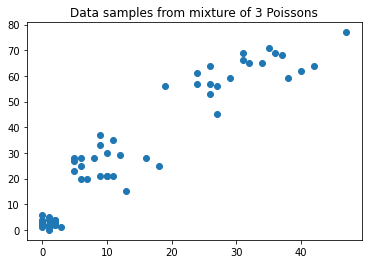

In [ ]:
# Some synthetic data - Multivariate Poisson
test_data = torch.cat(
    (torch.stack((Poisson(1).sample([20]), Poisson(3).sample([20])), dim = 1),
     torch.stack((Poisson(10).sample([20]), Poisson(25).sample([20])), dim = 1),
     torch.stack((Poisson(30).sample([20]), Poisson(60).sample([20])), dim = 1)))
plt.scatter(test_data[:, 0].cpu(), test_data[:, 1].cpu())
plt.title("Data samples from mixture of 3 Poissons")
plt.show()


100%|██████████| 5000/5000 [01:39<00:00, 50.11it/s]


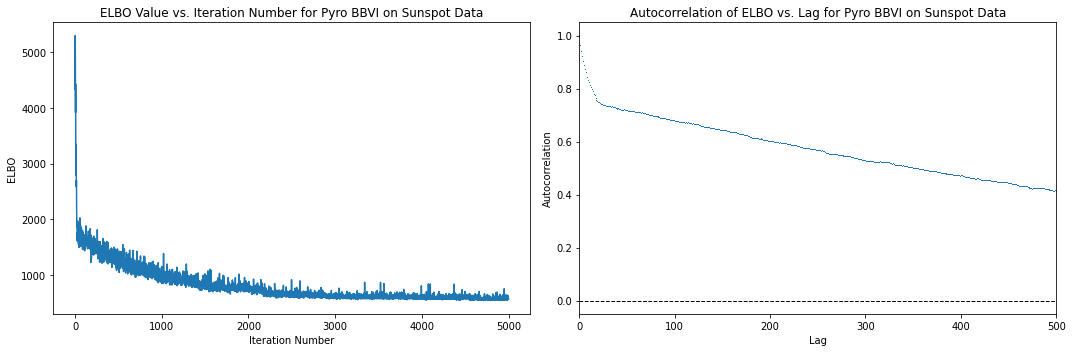

100%|██████████| 5000/5000 [01:42<00:00, 48.95it/s]


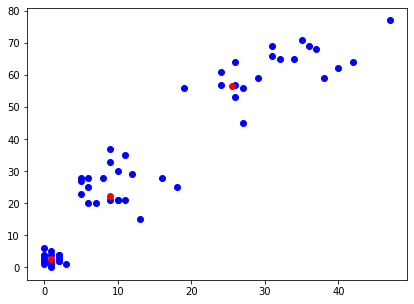

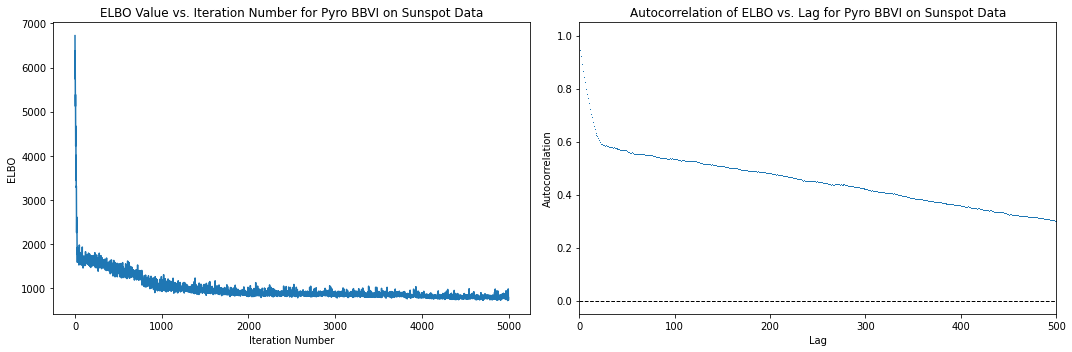

100%|██████████| 5000/5000 [01:40<00:00, 49.79it/s]


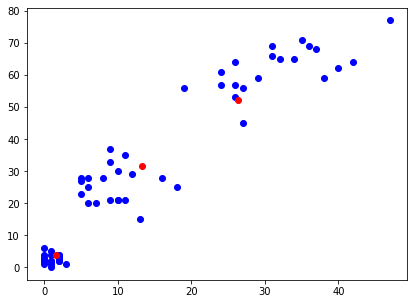

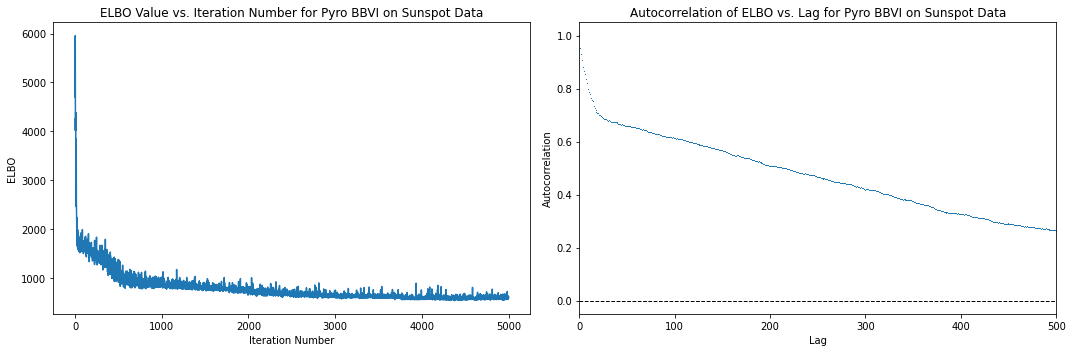

100%|██████████| 5000/5000 [01:42<00:00, 48.71it/s]


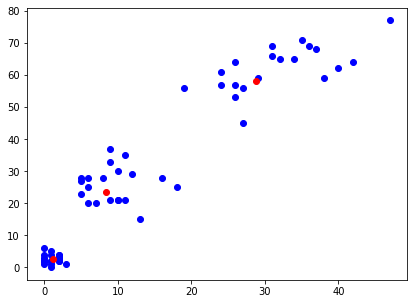

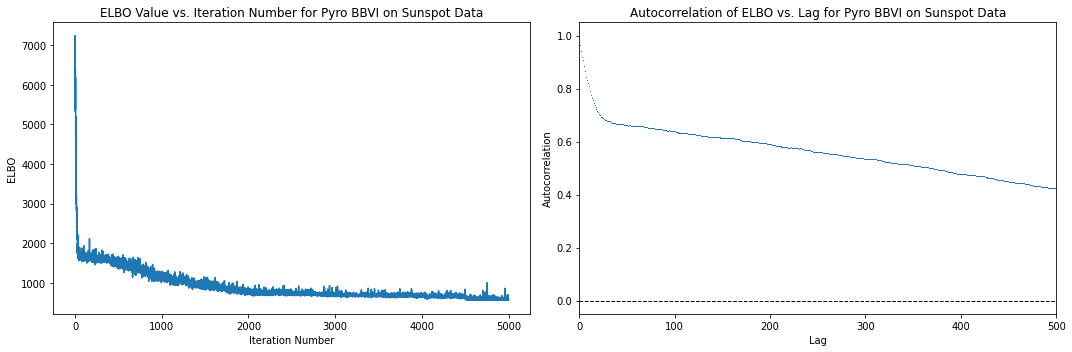

100%|██████████| 5000/5000 [01:43<00:00, 48.45it/s]


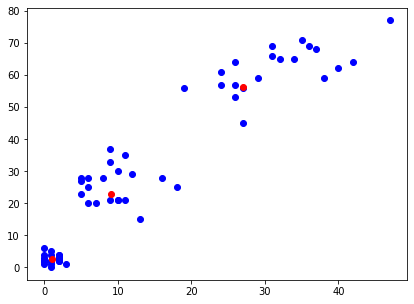

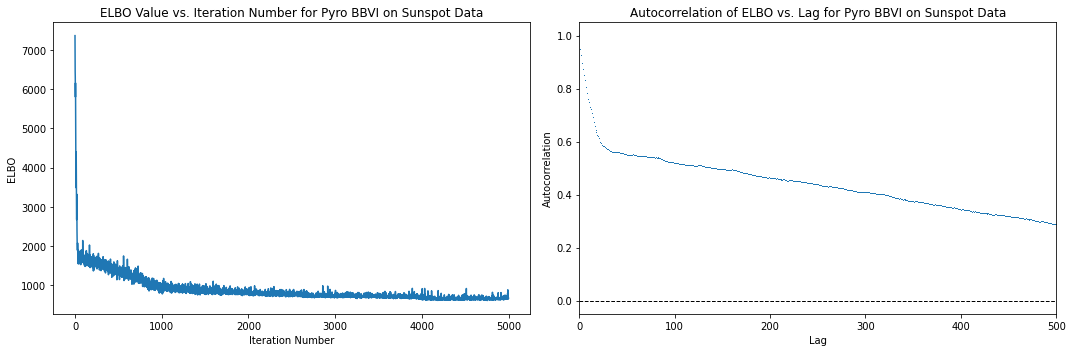

100%|██████████| 5000/5000 [01:42<00:00, 48.81it/s]


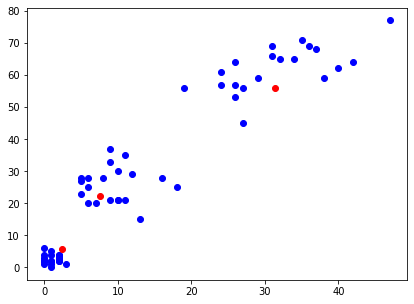

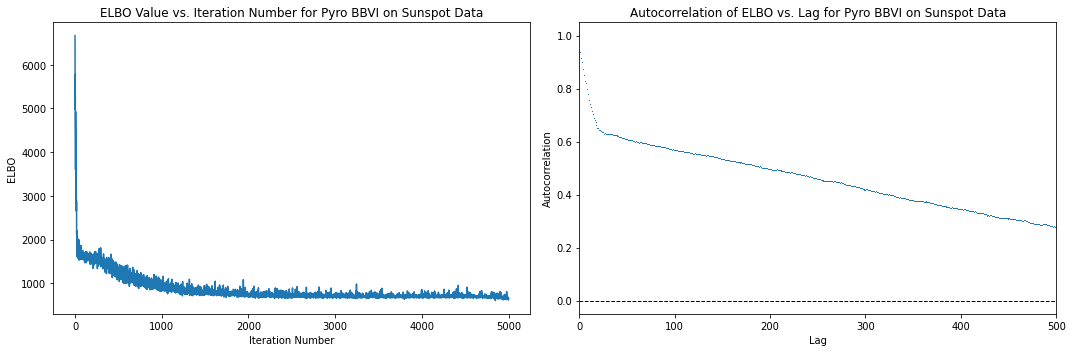

100%|██████████| 5000/5000 [01:42<00:00, 48.94it/s]


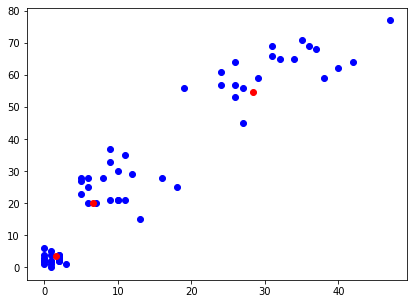

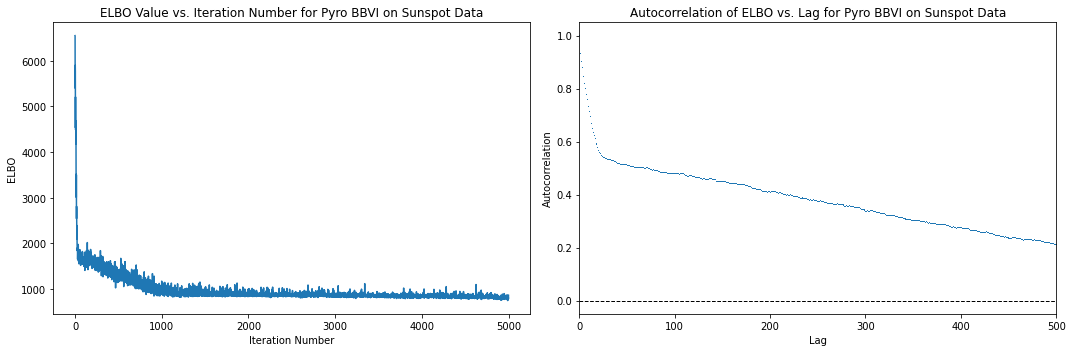

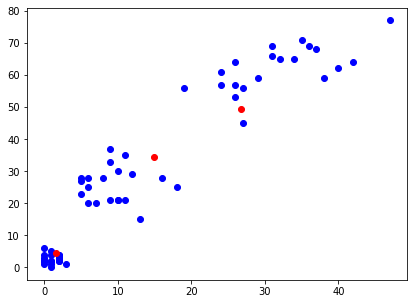

In [ ]:
# Try on test data
for alpha in [0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
  dppm_clust = DPPMClust(data = test_data, num_clusters = 3, alpha = 10.0, niter = 5000)  
  dppm_clust.var_inference()
  # Visualize
  dppm_clust.loss_viz()
  dppm_clust.cluster_2d_viz()

In [ ]:
# Try on real data
dppm_clust = DPPMClust(data = torch.tensor(data), num_clusters = 20, alpha = 10.0)
dppm_clust.var_inference()

100%|██████████| 1500/1500 [00:58<00:00, 25.81it/s]


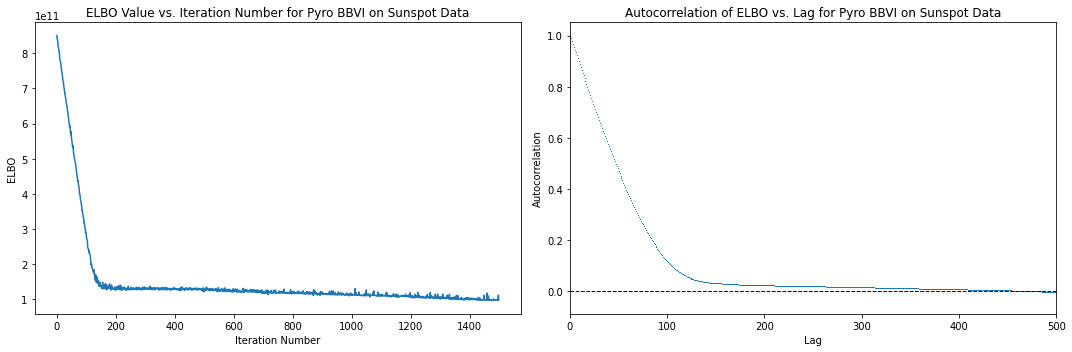

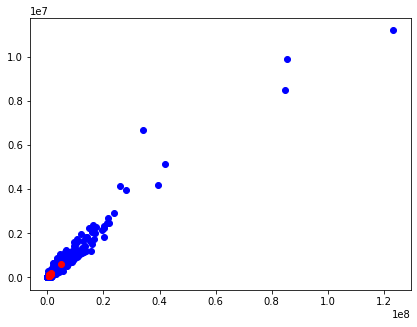

In [ ]:
dppm_clust.loss_viz()
dppm_clust.cluster_2d_viz()

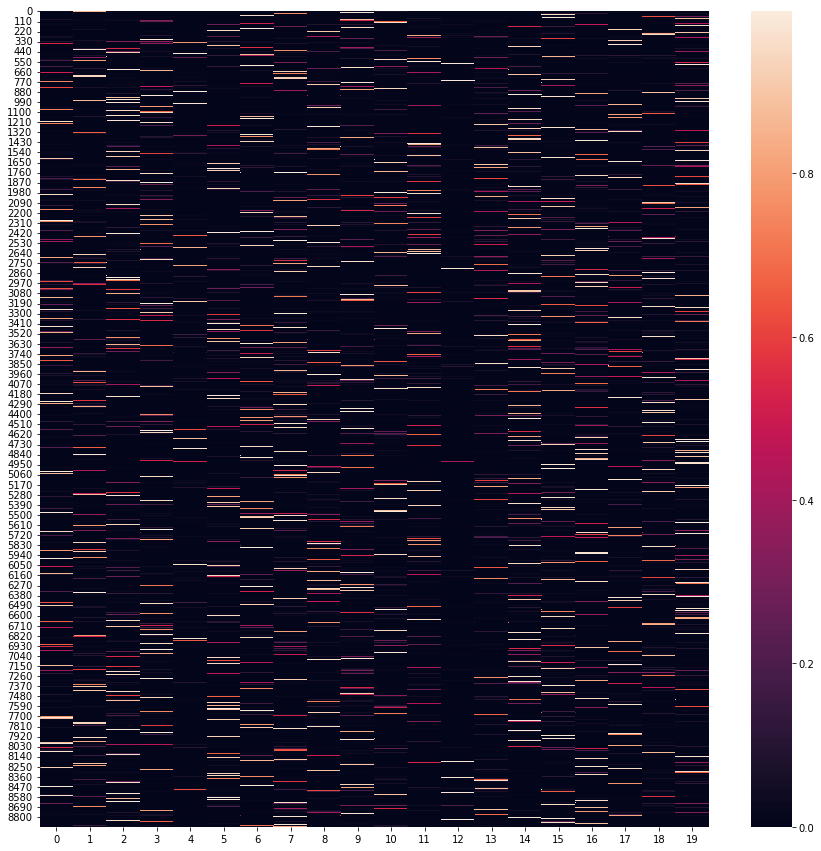

In [ ]:
probs = pyro.param("phi").detach().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)

In [ ]:
clusters = collections.defaultdict(list)
clusters_counts = collections.Counter()
i = 0
for row in probs:
    cluster_idx = np.argmax(row) + 1
    clusters[cluster_idx].append(i)
    clusters_counts[cluster_idx] += 1
    i += 1

In [ ]:
pprint(clusters_counts)

Counter({20: 515,
         3: 515,
         8: 510,
         1: 509,
         7: 507,
         17: 499,
         2: 496,
         4: 492,
         16: 492,
         15: 491,
         9: 485,
         19: 481,
         18: 476,
         10: 462,
         6: 461,
         14: 452,
         12: 442,
         11: 394,
         5: 157,
         13: 70})


In [ ]:
pairwise = probs @ probs.T
fig, axs = plt.subplots(figsize = (15, 15))
#sns.heatmap(pairwise)
plt.close()

In [ ]:
data = df.to_numpy(dtype = int)
data = np.log10(data + 1)


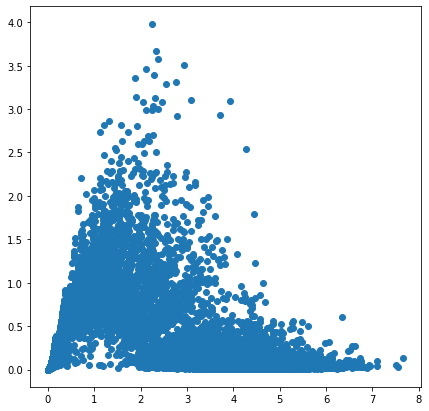

In [ ]:
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(np.mean(data, axis = 1), np.var(data, axis = 1))


In [ ]:
fig, axs = plt.subplots(figsize = (15, 15))
plt.plot(data[11])

In [ ]:
!rm counts_gene.tsv*
!wget http://duffel.rail.bio/recount/v2/SRP049475/counts_gene.tsv.gz

In [ ]:
df = pd.read_csv("counts_gene.tsv.gz", sep = "\t")
df

,SRR1639068,SRR1639069,SRR1639070,SRR1639071,SRR1639072,SRR1639073,SRR1639074,SRR1639075,SRR1639076,SRR1639077,SRR1639078,SRR1639079,SRR1639080,gene_id
0,112919,335410,335583,430326.0,118605,66643,67541,146871,98115,135331,73339,106275,55995,ENSG00000000003.14
1,397,299,496,685.0,820,1009,1365,300,8187,3506,31994,8997,17605,ENSG00000000005.5
2,75674,75376,64362,82255.0,66140,54228,51435,45096,53171,60000,51513,58593,50219,ENSG00000000419.12
3,17520,44156,43281,51083.0,39827,36214,36373,49604,37969,44092,38498,42561,40889,ENSG00000000457.13
4,35195,61428,53804,73222.0,50909,21843,20408,36397,30015,32419,20240,26208,17281,ENSG00000000460.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58032,0,0,0,0.0,0,0,0,53,0,56,0,0,0,ENSG00000283695.1
58033,610,459,446,800.0,0,108,198,1295,587,806,433,873,890,ENSG00000283696.1
58034,872,2227,1770,3020.0,755,490,1373,2144,856,2722,1228,1194,2486,ENSG00000283697.1
58035,0,0,0,117.0,39,111,374,200,299,81,0,0,454,ENSG00000283698.1


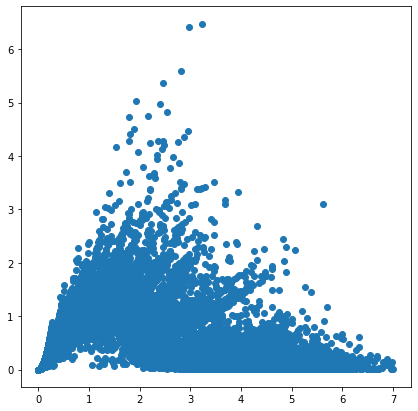

In [ ]:
df = df.drop(columns=['gene_id'])
data = df.to_numpy(dtype = int)
data = np.log10(data + 1)
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(np.mean(data, axis = 1), np.var(data, axis = 1))

In [ ]:
df = df.drop(columns=['gene_id'])
data = df.to_numpy(dtype = int)
data = np.log10(data + 1)
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(np.mean(data, axis = 1), np.var(data, axis = 1))

In [ ]:
!wget https://github.com/xuebaliang/scDMFK/raw/master/dataset/Young/data.h5


--2021-11-29 03:44:27--  https://github.com/xuebaliang/scDMFK/raw/master/dataset/Young/data.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuebaliang/scDMFK/master/dataset/Young/data.h5 [following]
--2021-11-29 03:44:27--  https://raw.githubusercontent.com/xuebaliang/scDMFK/master/dataset/Young/data.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21033569 (20M) [application/octet-stream]
Saving to: ‘data.h5’

data.h5             100%[===================>]  20.06M   123MB/s    in 0.2s    

2021-11-29 03:44:28 (123 MB/s) - ‘data.h5’ saved [21033569/21033569]



In [ ]:
def empty_safe(fn, dtype):
    def _fn(x):
        if x.size:
            return fn(x)
        return x.astype(dtype)
    return _fn

decode = empty_safe(np.vectorize(lambda _x: _x.decode("utf-8")), str)

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data

def dict_from_group(group):
    assert isinstance(group, h5py.Group)
    d = dotdict()
    for key in group:
        if isinstance(group[key], h5py.Group):
            value = dict_from_group(group[key])
        else:
            value = read_clean(group[key][...])
        d[key] = value
    return d

def read_data(filename, sparsify=False, skip_exprs=False):
    with h5py.File(filename, "r") as f:
        obs = pd.DataFrame(dict_from_group(f["obs"]), index=decode(f["obs_names"][...]))
        var = pd.DataFrame(dict_from_group(f["var"]), index=decode(f["var_names"][...]))
        uns = dict_from_group(f["uns"])
        if not skip_exprs:
            exprs_handle = f["exprs"]
            if isinstance(exprs_handle, h5py.Group):
                mat = sp.sparse.csr_matrix((exprs_handle["data"][...], exprs_handle["indices"][...],
                                               exprs_handle["indptr"][...]), shape=exprs_handle["shape"][...])
            else:
                mat = exprs_handle[...].astype(np.float32)
                if sparsify:
                    mat = sp.sparse.csr_matrix(mat)
        else:
            mat = sp.sparse.csr_matrix((obs.shape[0], var.shape[0]))
    return mat, obs, var, uns


In [ ]:
mat, obs, var, uns = read_data("data.h5")
X = np.array(mat.toarray())
cell_name = np.array(obs["cell_type1"])
cell_type, cell_label = np.unique(cell_name, return_inverse=True)

In [ ]:
min_cells = 5
min_counts = 5
highly_genes = 5000

adata = scanpy.AnnData(X)
adata.obs["Group"] = cell_label
scanpy.pp.filter_genes(adata, min_cells = min_cells)
scanpy.pp.filter_cells(adata, min_counts = min_counts)
scanpy.pp.normalize_per_cell(adata)
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
scanpy.pp.log1p(adata)
scanpy.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = highly_genes, subset=True)
print(adata.X.shape)

(5685, 5000)


In [ ]:
# Now keep only the most highly expressed genes
idx_to_keep = np.array(adata.var.highly_variable.index, dtype=np.int)
counts = np.array(X[:, idx_to_keep], dtype = int)
#counts = np.array(adata.X)

array([0, 0, 0, ..., 0, 0, 0])

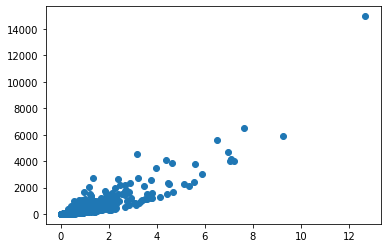

In [ ]:
plt.scatter(np.mean(counts, axis = 1), np.var(counts, axis = 1))

In [ ]:
# Try on real data
dppm_clust = DPMMClust(niter = 5000, data = torch.tensor(counts), num_clusters = 11, alpha = 0.5)
dppm_clust.var_inference()

100%|██████████| 5000/5000 [13:03<00:00,  6.38it/s]


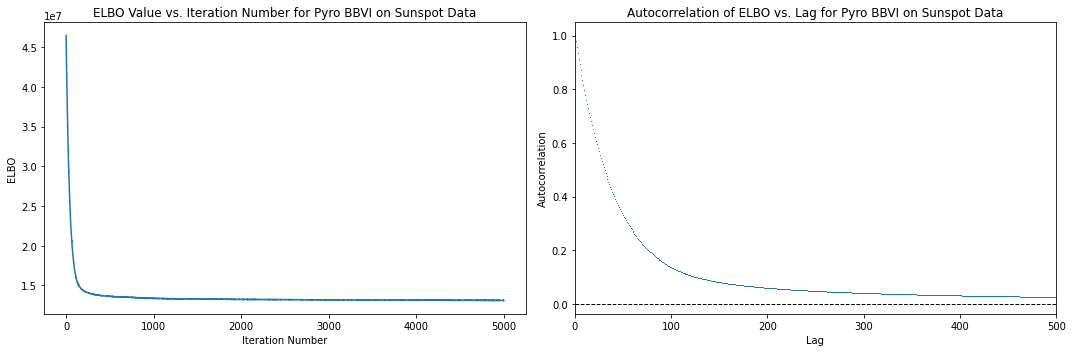

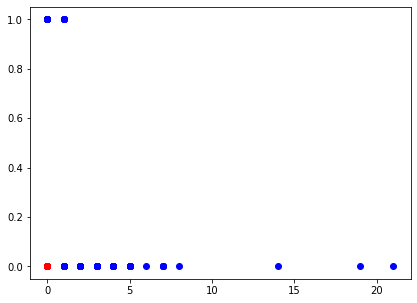

In [ ]:
dppm_clust.loss_viz()
dppm_clust.cluster_2d_viz()

In [ ]:
probs = pyro.param("phi").detach().cpu().numpy()
clusters = collections.defaultdict(list)
clusters_obs = []
i = 0
for row in probs:
    cluster_idx = np.argmax(row) + 1
    clusters[cluster_idx].append(i)
    clusters_obs.append(cluster_idx)
    i += 1

clusters_counts = collections.Counter(clusters_obs)
pprint(sorted(clusters_counts.items()))

[(1, 521),
 (2, 527),
 (3, 520),
 (4, 544),
 (5, 487),
 (6, 533),
 (7, 522),
 (8, 497),
 (9, 509),
 (10, 535),
 (11, 490)]


In [ ]:
pprint(sorted(collections.Counter(cell_label).items()))


In [ ]:
dppm_clust = DPMMClust(data = torch.tensor(counts), n_iter = 5000, num_clusters = 11, alpha = 1.0)
dppm_clust.var_inference()

  0%|          | 0/1500 [00:00<?, ?it/s]


NotImplementedError: ignored

In [ ]:
probs = pyro.param("phi").detach().numpy()
clusters = collections.defaultdict(list)
clusters_obs = []
i = 0
for row in probs:
    cluster_idx = np.argmax(row) + 1
    clusters[cluster_idx].append(i)
    clusters_obs.append(cluster_idx)
    i += 1

clusters_counts = collections.Counter(clusters_obs)
pprint(sorted(clusters_counts.items()))

[(1, 550),
 (2, 497),
 (3, 521),
 (4, 536),
 (5, 502),
 (6, 520),
 (7, 518),
 (8, 512),
 (9, 493),
 (10, 538),
 (11, 498)]


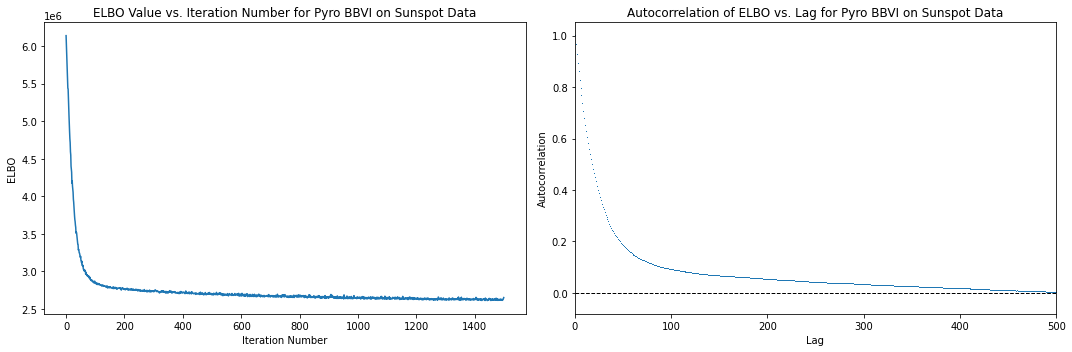

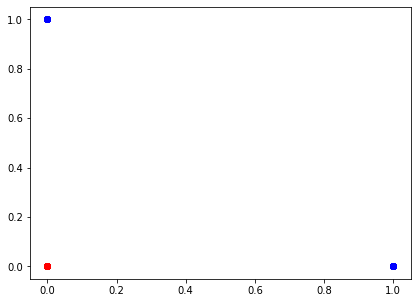

In [ ]:
dppm_clust.loss_viz()
dppm_clust.cluster_2d_viz()

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [ ]:
probs[0:10]

array([[3.09032708e-01, 2.72626858e-02, 1.23621719e-02, 4.33526367e-01,
        5.02389105e-17, 4.20790464e-02, 4.39335546e-03, 9.46088359e-02,
        5.77865094e-02, 9.96590033e-03, 8.98232684e-03],
       [1.42066914e-04, 2.61602141e-02, 2.11036275e-03, 2.94897472e-04,
        4.85124299e-03, 9.62406695e-01, 2.45333853e-04, 6.29262766e-04,
        6.64543302e-04, 6.61687343e-04, 1.83375378e-03],
       [7.73915425e-02, 4.81416821e-04, 2.51234509e-02, 8.65801156e-01,
        2.24378076e-03, 3.19596985e-03, 1.10650184e-02, 1.05526217e-34,
        7.26595800e-03, 7.20510073e-03, 2.26603879e-04],
       [1.38550503e-02, 1.24714259e-16, 1.36147172e-03, 2.61532958e-03,
        3.72079294e-03, 7.27888616e-03, 2.51902180e-04, 6.87862945e-25,
        1.65867209e-02, 9.52595234e-01, 1.73460948e-03],
       [6.56770170e-03, 1.14214141e-03, 9.07518249e-03, 4.20623599e-03,
        9.46808517e-01, 4.29506227e-03, 1.38691196e-03, 2.33985726e-02,
        3.11955228e-03, 7.90307906e-21, 1.98242106e-